In [1]:
import pandas as pd
import csv
import os
import numpy as np
import datetime
from xlsxwriter.workbook import Workbook
from xlsxwriter import Workbook
import time
import pytz
from sklearn import mixture
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import warnings
from matplotlib import cm
import collections

warnings.simplefilter('ignore')

In [2]:
# Directories
Working_dir = os.getcwd()
Data_dir = os.path.join(Working_dir, "Raw data")
Data_prep_dir = os.path.join(Working_dir, 'Preprocessed data')
Output_dir = os.path.join(Working_dir, 'Analysis')
Plots_dir = os.path.join(Output_dir, 'Plots')

In [3]:
selected_feat_df = pd.read_csv(os.path.join( Output_dir, 'selected_feat_clustered_df.csv'), sep=';', index_col=0 )

In [35]:
selected_feat_df[selected_feat_df.node_id == 1].unix_timestamp.values

array([1.52639315e+09, 1.52639518e+09, 1.52639721e+09, ...,
       1.54263485e+09, 1.54263565e+09, 1.54263644e+09])

In [1]:
for one_node_id in selected_feat_df.node_id.unique():
    one_node = selected_feat_df[selected_feat_df.node_id == one_node_id].copy()
    temp_difference_mins = ( one_node['unix_timestamp'][1:].values - \
                                one_node['unix_timestamp'][:-1].values ) / 60.
#     print( one_node_id, '\n', np.round(len(temp_difference_mins[temp_difference_mins<30])/len(temp_difference_mins)*100,5), \
#            np.round(np.mean(temp_difference_mins[temp_difference_mins<30]), 3),'\n\n')

In [ ]:
bins = np.arange(0,500,50)

In [24]:
len(temp_difference_mins[temp_difference_mins<30])/len(temp_difference_mins)

0.9983299075025693

In [20]:
counter = collections.Counter(temp_difference_mins)

In [4]:
# selected_feat_df.loc[:, 'cluster_center_exh_temp'] = 0

# selected_feat_df.loc[:, 'cluster_center_cpu_temp_1'] = 0
# selected_feat_df.loc[:, 'cluster_center_cpu_temp_2'] = 0

# selected_feat_df.loc[:, 'cluster_center_exh_cpu_temp_1'] = 0
# selected_feat_df.loc[:, 'cluster_center_exh_cpu_temp_2'] = 0
# selected_feat_df.loc[:, 'cluster_center_exh_cpu_temp_3'] = 0


# selected_feat_df.loc[:, 'cluster_exh_temp'] = np.nan
# selected_feat_df.loc[:, 'cluster_cpu_temp'] = np.nan
# selected_feat_df.loc[:, 'cluster_exh_cpu_temp'] = np.nan

# selected_feat_df.head()

In [ ]:
x_cols = 'exh_temp'
cluster_col = 'cluster_exh_temp'
center_cols = 'cluster_center_exh_temp'
temp_title  = 'Exh temperature based'

# x_cols = ['cpu1_temp', 'cpu2_temp']
# cluster_col = 'cluster_cpu_temp'
# center_cols  = ['cluster_center_cpu_temp_1', 'cluster_center_cpu_temp_2']
# temp_title  = 'CPU temperature based'

# x_cols = ['exh_temp', 'cpu1_temp', 'cpu2_temp']
# cluster_col = 'cluster_exh_cpu_temp'
# center_cols  = ['cluster_center_exh_cpu_temp_1', 'cluster_center_exh_cpu_temp_2', 'cluster_center_exh_cpu_temp_3'] 
# temp_title  = 'Exhaust & CPU temperature based'

Number of rows in consolidated table

In [6]:
selected_feat_df.shape[0]

3347335

## Clustering

Sequence of N clusters. N = 

In [7]:
selected_feat_df.shape[0]/215

15569.0

### Number of clusters

Comment: cluster_col = column with cluster label

- silhouette index (distance of members of one cluster from all the other clusters) only grows with increasing number of cluster
- elbow method shows k = 3...6 are good, for k=3 silhouette index = max, for exhaust temp
- elbow method: k = 5 for CPU1,2 temp, while silhouette does not give results
- elbow method: k = 6 for exh + CPU1,2 temp, silhouette gives k = 3

In [4]:
def columns_for_clustering(temp_base=['exh','cpu', 'exh_cpu']):
    
    if ( temp_base == 'exh' ):
        k = 3
        return( 'exh_temp', 'cluster_exh_temp', 'cluster_center_exh_temp', 'Exh temperature based', k )
    elif ( temp_base == 'cpu' ):
        k = 5
        return( ['cpu1_temp', 'cpu2_temp'], 'cluster_cpu_temp', \
                ['cluster_center_cpu_temp_1', 'cluster_center_cpu_temp_2'], \
                'CPU temperature based', k )
    elif ( temp_base == 'exh_cpu' ):
        k = 3
        return( ['exh_temp', 'cpu1_temp', 'cpu2_temp'], 'cluster_exh_cpu_temp', \
                ['cluster_center_exh_cpu_temp_1', 'cluster_center_exh_cpu_temp_2', 'cluster_center_exh_cpu_temp_3'], \
                'Exhaust & CPU temperature based', k )
    else:
        print( 'Incorrect temperature base input. Expected one of', ['exh','cpu', 'exh_cpu'])
        

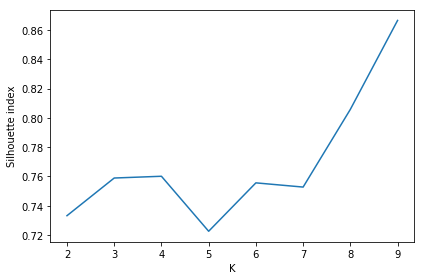

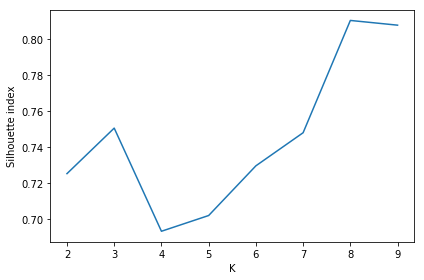

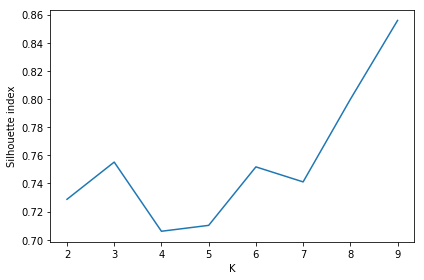

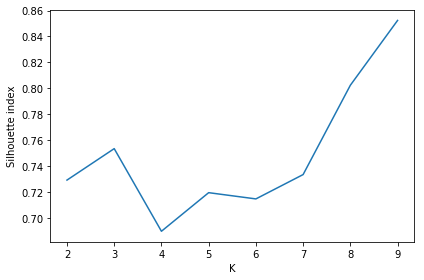

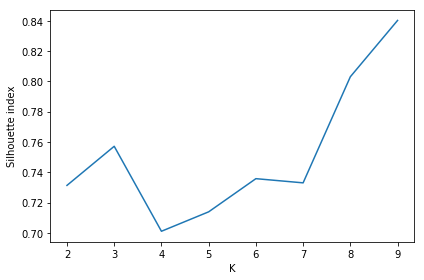

In [27]:
cluster_type = 'exh'
x_cols, cluster_col, center_cols, temp_title, k = columns_for_clustering(cluster_type)

for i in range(5):
    silhouette_avg = []
    k_min = 2
    k_max = 10
    for k in range(k_min,k_max):
        selected_feat_df.loc[ 215*i : 215*(i+1), cluster_col] = np.nan
        
        X = selected_feat_df.loc[ 215*i : 215*(i+1), x_cols].dropna()
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X.values.reshape(-1,1))
        
        silhouette_avg.append(silhouette_score(X.values.reshape(-1,1), kmeans.labels_))#.reshape(-1,1)
    fig, axes = plt.subplots()
    plt.plot(range(k_min,k_max), silhouette_avg)
    plt.xticks(range(k_min,k_max))
    plt.xlabel('K')
    plt.ylabel('Silhouette index')
#     plt.title('Average silhouette index\n' + temp_title + '\nclustering ' + str(i+1))
    plt.tight_layout()

    fig.savefig(os.path.join( Plots_dir, \
                          'Silhouette_for_'+cluster_type+'_clusterNo_'+str(i+1)+'.png' ), dpi=900, bbox_inches='tight' )
    plt.show()
    print('\n')

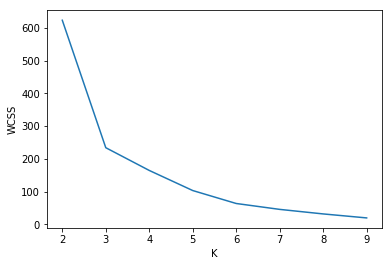

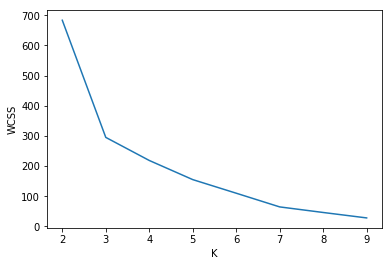

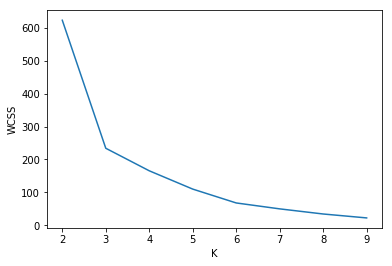

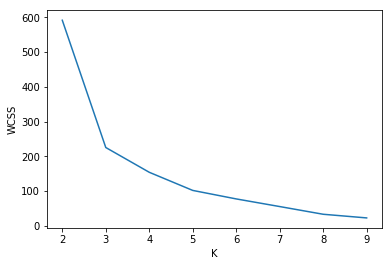

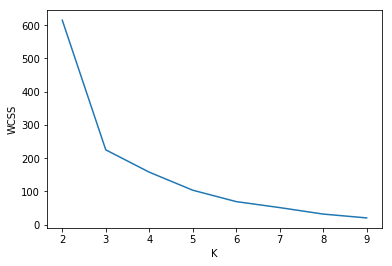

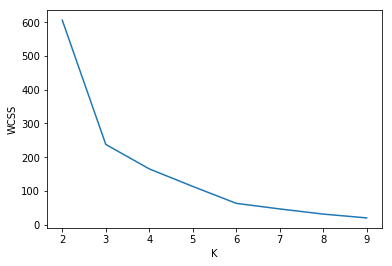

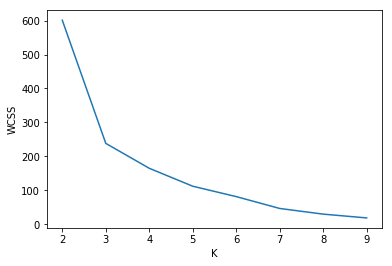

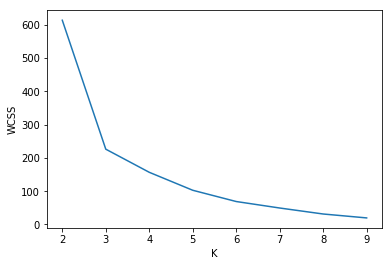

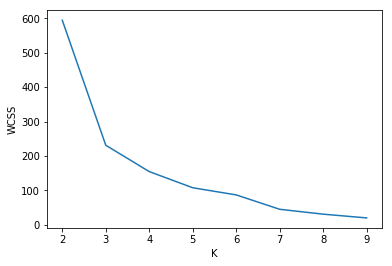

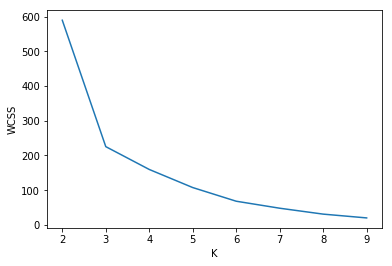

In [26]:
cluster_type = 'exh'
x_cols, cluster_col, center_cols, temp_title, k = columns_for_clustering(cluster_type)

for i in range(10):
    wcss = []
    
    k_min = 2
    k_max = 10
    
    for k in range(k_min,k_max):
        selected_feat_df.loc[ 215*i : 215*(i+1), cluster_col] = np.nan
        
        X = selected_feat_df.loc[ 215*i : 215*(i+1), x_cols].dropna()
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X.values.reshape(-1,1))
        
        silhouette_avg = silhouette_score(X.values.reshape(-1,1), kmeans.labels_)
        wcss.append(kmeans.inertia_)
    fig, axes = plt.subplots()
    plt.plot(range(k_min,k_max), wcss)
    plt.xticks(range(k_min,k_max))
    plt.xlabel('K')
    plt.ylabel('WCSS')
#     plt.title('Within cluster sum of squares (WCSS)\n' + temp_title + ' clustering ' + str(i+1))
    fig.savefig(os.path.join( Plots_dir, \
                          'WCSS_for_'+cluster_type+'_clusterNo_'+str(i+1)+'.png' ), dpi=900, bbox_inches='tight' )
    plt.show()
    print('\n')

In [51]:
x_cols, cluster_col, center_cols, temp_title, k = columns_for_clustering('cpu')
for i in range( int( selected_feat_df.shape[0] / 215 )):
    selected_feat_df.loc[ 215*i : 215*(i+1), cluster_col] = np.nan
    
    X = selected_feat_df.loc[ 215*i : 215*(i+1), x_cols].dropna()
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X.values)#.reshape(-1, 1))
    
    c = np.arange(k)
    a, idx = zip(*sorted(zip(kmeans.cluster_centers_.sum(axis=1).tolist(), c.tolist())))
    inc = np.zeros_like(idx)
    inc[np.array(idx)] = np.arange(k)
    selected_feat_df.loc[ X.index, cluster_col] = inc[kmeans.labels_]
    selected_feat_df.loc[ X.index, center_cols] = kmeans.cluster_centers_[kmeans.labels_]
    if ( i % 1000 == 0):
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000


In [53]:
selected_feat_df.to_csv(path_or_buf=os.path.join( Output_dir, 'selected_feat_clustered_df.csv'), sep=';')

### Count number of nodes in each cluster

In [5]:
count = {}
for cluster_type in ['exh', 'cpu', 'exh_cpu']:
    count[cluster_type] = selected_feat_df.groupby(['node_id', 'cluster_' + cluster_type + '_temp']).\
                                size().to_frame( cluster_type + '_count' ).reset_index().set_index('node_id')

### Find which nodes appear most frequently in the clusters with high temperature ("danger zone")

Find percentage of occurrence for the node in a cluster

In [6]:
for cluster_type in ['exh','cpu', 'exh_cpu']:
    print(cluster_type)
    count[cluster_type].loc[:,'percent_occur'] = ( count[cluster_type] / \
                                             count[cluster_type].groupby('node_id').agg({ cluster_type+'_count': 'sum' })).\
                                             loc[:,cluster_type+'_count']

exh
cpu
exh_cpu


In [2]:
plot_data = {}
for cluster_type in ['exh','cpu', 'exh_cpu']:
    
    height = 44
    plot_data[cluster_type] = {}
    for label in count[cluster_type].loc[:, 'cluster_' + cluster_type + '_temp'].unique():
        plot_data[cluster_type][label] = pd.DataFrame(columns = ['x', 'y', 's'], index = count[cluster_type].index.unique(), data = 0)
        plot_data[cluster_type][label].x = plot_data[cluster_type][label].index // height + 0.2 * label
        plot_data[cluster_type][label].y = plot_data[cluster_type][label].index % height *100
        count_df = count[cluster_type][count[cluster_type].loc[:, 'cluster_' + cluster_type + '_temp'] == label].copy()
        plot_data[cluster_type][label].s = [ count_df.loc[x, 'percent_occur'] \
                                            if x in count_df.index \
                                            else 0 \
                                            for x in plot_data[cluster_type][label].index ]

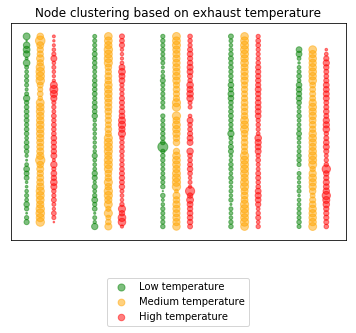

In [15]:
cluster_type = 'exh'
# data = plot_data[cluster_type][0].append(plot_data[cluster_type][1]).append(plot_data[cluster_type][2])

plt.figsize=(14, 10)
fig, axes = plt.subplots()

colors = ['green']*plot_data[cluster_type][0].shape[0] + \
         ['orange']*plot_data[cluster_type][1].shape[0] + \
         ['red']*plot_data[cluster_type][2].shape[0]
green = plt.scatter( plot_data[cluster_type][0].x, plot_data[cluster_type][0].y, plot_data[cluster_type][0].s * 100, \
                     c='green', alpha=0.5 )
orange = plt.scatter( plot_data[cluster_type][1].x, plot_data[cluster_type][1].y, plot_data[cluster_type][1].s * 100, \
                      c='orange', alpha=0.5 )
red = plt.scatter( plot_data[cluster_type][2].x, plot_data[cluster_type][2].y, plot_data[cluster_type][2].s * 100, \
                   c='red', alpha=0.5)

# plt.xlim(-.1, .3)
plt.yticks([])
plt.xticks([])

plt.legend( (green, orange, red), ('Low temperature', 'Medium temperature', 'High temperature'), \
            loc='upper center', bbox_to_anchor=(0.5, -0.15))
plt.title('Node clustering based on exhaust temperature')
plt.show()

In [10]:
red_percentage, nodes_sorted = zip(*sorted(zip(coord_size[2].s, coord_size[2].index)))

In [8]:
cluster_characts = {}
# writer = pd.ExcelWriter( os.path.join( Output_dir, 'cluster_characteristics.xlsx'), engine='xlsxwriter')

for cluster_type in ['exh','cpu', 'exh_cpu']:
    x_cols, cluster_col, center_cols, temp_title, k = columns_for_clustering( cluster_type )
    
    if cluster_type == 'exh':
        cols = [x_cols, center_cols]
    else:
        cols = x_cols + center_cols
        
    cluster_characts[cluster_type] = pd.DataFrame( columns=cols, \
                                                   index=np.arange(k), data = np.nan )
    for index, row in cluster_characts[cluster_type].iterrows():
        cluster_characts[cluster_type].loc[index, x_cols] = \
            selected_feat_df[selected_feat_df.loc[:,cluster_col] == index].loc[:, x_cols].mean()
        cluster_characts[cluster_type].loc[index, center_cols] = \
            selected_feat_df[selected_feat_df.loc[:,cluster_col] == index].loc[:, center_cols].mean()

#     cluster_characts[cluster_type].to_excel( writer, sheet_name=cluster_type )
# writer.save()

In [9]:
cluster_characts['exh']

,exh_temp,cluster_center_exh_temp
0,30.065119,30.073310
1,37.249083,37.241304
2,41.661836,41.661551


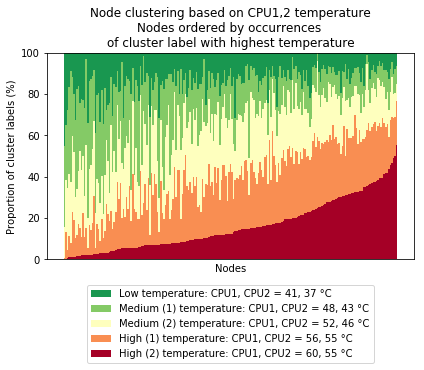

In [85]:
cluster_type = 'cpu'

x_cols, cluster_col, center_cols, temp_title, k = columns_for_clustering( cluster_type )
red_percentage, nodes_sorted = zip(*sorted(zip(plot_data[cluster_type][k-1].s, plot_data[cluster_type][k-1].index)))

plt.figsize=(6, 7)
fig, ax = plt.subplots()

# fig.suptitle('Node clustering based on exhaust temperature\n'+\
#              'Nodes ordered by occurrences of cluster label wiht highest temperature')
# fig.subplots_adjust(top=0.9)

N = 215*100
ind = np.arange(0, N, 100)
w = 100

p = []
cmap = cm.get_cmap('RdYlGn')
gradient = np.linspace(0, 256, k)

bottom = {}
for i in range(k-1, -1, -1):
    bottom_sum = plot_data[cluster_type][4].s[list(nodes_sorted)].values*100
    for j in range(i, k-1):
        bottom_sum += plot_data[cluster_type][j].s[list(nodes_sorted)].values*100
    bottom[i] = bottom_sum

p5 = ax.bar(ind, plot_data[cluster_type][4].s[list(nodes_sorted)].values*100, color=cmap(0), \
            width=w)
p4 = ax.bar(ind, plot_data[cluster_type][3].s[list(nodes_sorted)].values*100, color=cmap(0.25), \
            bottom=bottom[4], width=w)
p3 = ax.bar(ind, plot_data[cluster_type][2].s[list(nodes_sorted)].values*100, color=cmap(0.5), \
            bottom=bottom[3], width=w)
p2 = ax.bar(ind, plot_data[cluster_type][1].s[list(nodes_sorted)].values*100, \
            bottom = bottom[2], \
            color=cmap(0.75), \
            width=w )
p1 = ax.bar(ind, plot_data[cluster_type][0].s[list(nodes_sorted)].values*100, \
            bottom=bottom[1], \
            color=cmap(.9),  \
            width=w)
#              bottom = (plot_data[cluster_type][2].s[list(nodes_sorted)].values + \
#                         plot_data[cluster_type][1].s[list(nodes_sorted)].values)*100)


plt.xlabel('Nodes')
plt.ylabel('Proportion of cluster labels (%)')

ax.set_ylim(0,100)
ax.set_xticks([])

# lgd = ax.legend((p1[0], p2[0], p3[0]), \
#                   ('Low temperature ('+str(int(cluster_characts['exh'].loc[0,'exh_temp'])) +' °C)', \
#                    'Medium temperature ('+str(int(cluster_characts['exh'].loc[1,'exh_temp'])) +' °C)', \
#                    'High temperature  ('+str(int(cluster_characts['exh'].loc[2,'exh_temp'])) +' °C)'), \
#                    loc='upper center', bbox_to_anchor=(0.5, -0.1))

# lgd = ax.legend((p1[0], p2[0], p3[0]), \
#                   ('Low temperature: exhaust, CPU1, CPU2 = ' + \
#                    str(int(cluster_characts[cluster_type].loc[0,'exh_temp'])) +', '+ \
#                    str(int(cluster_characts[cluster_type].loc[0,'cpu1_temp'])) +', '+ \
#                    str(int(cluster_characts[cluster_type].loc[0,'cpu2_temp'])) + ' °C', \
#                    'Medium temperature: exhaust, CPU1, CPU2 = ' + \
#                    str(int(cluster_characts[cluster_type].loc[1,'exh_temp'])) +', '+ \
#                    str(int(cluster_characts[cluster_type].loc[1,'cpu1_temp'])) +', '+ \
#                    str(int(cluster_characts[cluster_type].loc[1,'cpu2_temp'])) + ' °C', \
#                    'High temperature: exhaust, CPU1, CPU2 = ' + \
#                    str(int(cluster_characts[cluster_type].loc[2,'exh_temp'])) +', '+ \
#                    str(int(cluster_characts[cluster_type].loc[2,'cpu1_temp'])) +', '+ \
#                    str(int(cluster_characts[cluster_type].loc[2,'cpu2_temp'])) + ' °C'), \
#                    loc='upper center', bbox_to_anchor=(0.5, -0.1))


lgd = ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), \
                  ('Low temperature: CPU1, CPU2 = ' + \
                   str(int(cluster_characts[cluster_type].loc[0,'cpu1_temp'])) +', '+ \
                   str(int(cluster_characts[cluster_type].loc[0,'cpu2_temp'])) + ' °C', \
                   'Medium (1) temperature: CPU1, CPU2 = ' + \
                   str(int(cluster_characts[cluster_type].loc[1,'cpu1_temp'])) +', '+ \
                   str(int(cluster_characts[cluster_type].loc[1,'cpu2_temp'])) + ' °C', \
                   'Medium (2) temperature: CPU1, CPU2 = ' + \
                   str(int(cluster_characts[cluster_type].loc[2,'cpu1_temp'])) +', '+ \
                   str(int(cluster_characts[cluster_type].loc[2,'cpu2_temp'])) + ' °C', \
                   'High (1) temperature: CPU1, CPU2 = ' + \
                   str(int(cluster_characts[cluster_type].loc[3,'cpu1_temp'])) +', '+ \
                   str(int(cluster_characts[cluster_type].loc[4,'cpu2_temp'])) + ' °C', \
                   'High (2) temperature: CPU1, CPU2 = ' + \
                   str(int(cluster_characts[cluster_type].loc[4,'cpu1_temp'])) +', '+ \
                   str(int(cluster_characts[cluster_type].loc[4,'cpu2_temp'])) + ' °C'), \
                   loc='upper center', bbox_to_anchor=(0.5, -0.1))

plt.title('Node clustering based on CPU1,2 temperature\n'+\
             'Nodes ordered by occurrences \nof cluster label with highest temperature')

plt.tight_layout()

fig.savefig(os.path.join( Plots_dir, \
                          'Clustering_cpu_temp_v2_fill.png' ), dpi=900, bbox_inches='tight' )
plt.show()

In [69]:
bottom.keys()

dict_keys([0, 1, 2, 3, 4])

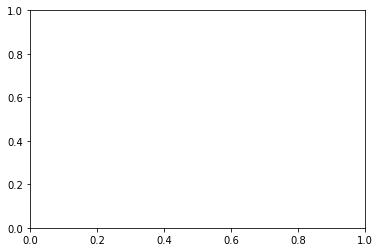

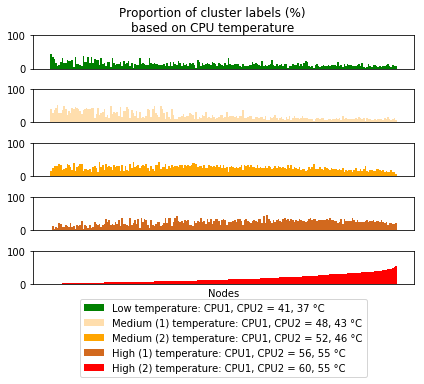

In [35]:
cluster_type = 'cpu'

x_cols, cluster_col, center_cols, temp_title, k = columns_for_clustering( cluster_type )
red_percentage, nodes_sorted = zip(*sorted(zip(plot_data[cluster_type][k-1].s, plot_data[cluster_type][k-1].index)))

plt.figsize=(6, 7)
fig, ax = plt.subplots()

N = 215*100
ind = np.arange(0, N, 100)
w = 100

p = []
cmap = cm.get_cmap('RdYlGn')
gradient = np.linspace(0, 256, k)

plt.figsize=(6, 7)

subp_max = 5
fig, axarr = plt.subplots(subp_max, sharex='col')

# fig.suptitle('Proportion of cluster labels (%)\nbased on exhaust temperature', x=0.5, y=1.05)
fig.suptitle('Proportion of cluster labels (%)\nbased on CPU temperature', x=0.5, y=1.05)


# fig.subplots_adjust(top=0.9)

fig.subplots_adjust(hspace=0)

N = 215*100
ind = np.arange(0, N, 100)
w = 100

p1 = axarr[0].bar(ind, plot_data[cluster_type][0].s[list(nodes_sorted)].values*100, color='green', width=w )
p2 = axarr[1].bar(ind, plot_data[cluster_type][1].s[list(nodes_sorted)].values*100, color='navajowhite', width=w )
p3 = axarr[2].bar(ind, plot_data[cluster_type][2].s[list(nodes_sorted)].values*100, color='orange',  width=w )
p4 = axarr[3].bar(ind, plot_data[cluster_type][3].s[list(nodes_sorted)].values*100, color='chocolate',  width=w )
p5 = axarr[4].bar(ind, plot_data[cluster_type][4].s[list(nodes_sorted)].values*100, color='red',  width=w )
for i in range(subp_max):
    axarr[i].set_ylim(0,100)
    axarr[i].set_xticks([])

# lgd = ax3.legend((p1[0], p2[0], p3[0]), \
#                   ('Low temperature ('+str(int(cluster_characts['exh'].loc[0,'exh_temp'])) +' °C)', \
#                    'Medium temperature ('+str(int(cluster_characts['exh'].loc[1,'exh_temp'])) +' °C)', \
#                    'High temperature  ('+str(int(cluster_characts['exh'].loc[2,'exh_temp'])) +' °C)'), \
#                   loc='upper center', bbox_to_anchor=(0.5, -0.3))

# lgd = ax3.legend((p1[0], p2[0], p3[0]), \
#                   ('Low temperature: exhaust, CPU1, CPU2 = ' + \
#                    str(int(cluster_characts[cluster_type].loc[0,'exh_temp'])) +', '+ \
#                    str(int(cluster_characts[cluster_type].loc[0,'cpu1_temp'])) +', '+ \
#                    str(int(cluster_characts[cluster_type].loc[0,'cpu2_temp'])) + ' °C', \
#                    'Medium temperature: exhaust, CPU1, CPU2 = ' + \
#                    str(int(cluster_characts[cluster_type].loc[1,'exh_temp'])) +', '+ \
#                    str(int(cluster_characts[cluster_type].loc[1,'cpu1_temp'])) +', '+ \
#                    str(int(cluster_characts[cluster_type].loc[1,'cpu2_temp'])) + ' °C', \
#                    'High temperature: exhaust, CPU1, CPU2 = ' + \
#                    str(int(cluster_characts[cluster_type].loc[2,'exh_temp'])) +', '+ \
#                    str(int(cluster_characts[cluster_type].loc[2,'cpu1_temp'])) +', '+ \
#                    str(int(cluster_characts[cluster_type].loc[2,'cpu2_temp'])) + ' °C'), \
#                    loc='upper center', bbox_to_anchor=(0.5, -0.3))

lgd = axarr[subp_max-1].legend((p1[0], p2[0], p3[0], p4[0], p5[0]), \
                  ('Low temperature: CPU1, CPU2 = ' + \
                   str(int(cluster_characts[cluster_type].loc[0,'cpu1_temp'])) +', '+ \
                   str(int(cluster_characts[cluster_type].loc[0,'cpu2_temp'])) + ' °C', \
                   'Medium (1) temperature: CPU1, CPU2 = ' + \
                   str(int(cluster_characts[cluster_type].loc[1,'cpu1_temp'])) +', '+ \
                   str(int(cluster_characts[cluster_type].loc[1,'cpu2_temp'])) + ' °C', \
                   'Medium (2) temperature: CPU1, CPU2 = ' + \
                   str(int(cluster_characts[cluster_type].loc[2,'cpu1_temp'])) +', '+ \
                   str(int(cluster_characts[cluster_type].loc[2,'cpu2_temp'])) + ' °C', \
                   'High (1) temperature: CPU1, CPU2 = ' + \
                   str(int(cluster_characts[cluster_type].loc[3,'cpu1_temp'])) +', '+ \
                   str(int(cluster_characts[cluster_type].loc[4,'cpu2_temp'])) + ' °C', \
                   'High (2) temperature: CPU1, CPU2 = ' + \
                   str(int(cluster_characts[cluster_type].loc[4,'cpu1_temp'])) +', '+ \
                   str(int(cluster_characts[cluster_type].loc[4,'cpu2_temp'])) + ' °C'), \
                   loc='upper center', bbox_to_anchor=(0.5, -0.3))

plt.xlabel('Nodes')

plt.tight_layout()
fig.savefig(os.path.join( Plots_dir, \
                          'Clustering_cpu_temp_v1_3_subplots.png' ), dpi=900, bbox_inches='tight' )
plt.show()

### Nodes in red range $\ge$ 50% of all timestamps

In [41]:
nodes_red_range = {}
for cluster_type in ['exh','cpu', 'exh_cpu']:
    x_cols, cluster_col, center_cols, temp_title, k = columns_for_clustering( cluster_type )
    if ( cluster_type == 'cpu' ):
        nodes_red_range[cluster_type] = count[cluster_type][(( count[cluster_type].loc[:, cluster_col] == k-1 ) | \
                                                             ( count[cluster_type].loc[:, cluster_col] == k-2 ))& \
                                                            ( count[cluster_type].loc[:, 'percent_occur'] >= 0.5 )].index
    else:
        nodes_red_range[cluster_type] = count[cluster_type][( count[cluster_type].loc[:, cluster_col] == k-1 ) & \
                                                            ( count[cluster_type].loc[:, 'percent_occur'] >= 0.5 )].index


In [49]:
set.intersection(set(nodes_red_range['exh']), set(nodes_red_range['exh_cpu']))

{30, 31, 45, 46, 48, 96, 183, 189}

### Final cluster value = most frequently occurred cluster label for this node

In [8]:
most_freq_clustering = {}
most_freq_red_range = {}
for cluster_type in ['exh','cpu', 'exh_cpu']:
    most_freq_clustering[cluster_type] = pd.DataFrame( index = count[cluster_type].index.unique(), 
                                                       columns = ['final_'+cluster_type+'_cluster'], data = 0)
    for index, row in most_freq_clustering[cluster_type].iterrows():
        if index != 106:
            argmax = count[cluster_type].loc[index, 'percent_occur'].values.argmax()
            most_freq_clustering[cluster_type].loc[index, 'final_'+cluster_type+'_cluster'] = \
                count[cluster_type].loc[index, 'cluster_'+cluster_type+'_temp'].values[argmax]
    x_cols, cluster_col, center_cols, temp_title, k = columns_for_clustering( cluster_type )
    most_freq_red_range[cluster_type] = most_freq_clustering[cluster_type][ most_freq_clustering[cluster_type].\
                                                  loc[:,'final_'+cluster_type+'_cluster'] == k-1].index
    if ( cluster_type == 'cpu' ):
        most_freq_red_range[cluster_type] = most_freq_clustering[cluster_type][( most_freq_clustering[cluster_type].\
                                                  loc[:,'final_'+cluster_type+'_cluster'] == k-1 ) | \
                                                                               ( most_freq_clustering[cluster_type].\
                                                  loc[:,'final_'+cluster_type+'_cluster'] == k-2 )].index

In [ ]:
most_freq_clustering = {}
most_freq_red_range = {}
for cluster_type in ['exh','cpu', 'exh_cpu']:
    most_freq_clustering[cluster_type] = pd.DataFrame( index = count[cluster_type].index.unique(), 
                                                       columns = ['final_'+cluster_type+'_cluster'], data = 0)
    for index, row in most_freq_clustering[cluster_type].iterrows():
        if index != 106:
            argmax = count[cluster_type].loc[index, 'percent_occur'].values.argmax()
            most_freq_clustering[cluster_type].loc[index, 'final_'+cluster_type+'_cluster'] = \
                count[cluster_type].loc[index, 'cluster_'+cluster_type+'_temp'].values[argmax]
    x_cols, cluster_col, center_cols, temp_title, k = columns_for_clustering( cluster_type )
    most_freq_red_range[cluster_type] = most_freq_clustering[cluster_type][ most_freq_clustering[cluster_type].\
                                                  loc[:,'final_'+cluster_type+'_cluster'] == k-1].index
    if ( cluster_type == 'cpu' ):
        most_freq_red_range[cluster_type] = most_freq_clustering[cluster_type][( most_freq_clustering[cluster_type].\
                                                  loc[:,'final_'+cluster_type+'_cluster'] == k-1 ) | \
                                                                               ( most_freq_clustering[cluster_type].\
                                                  loc[:,'final_'+cluster_type+'_cluster'] == k-2 )].index

In [12]:
cluster_type = 'exh'
most_freq_clustering[cluster_type][most_freq_clustering[cluster_type].loc[:, 'final_'+cluster_type+'_cluster'] == 0]

,final_exh_cluster
node_id,
29,0.0
37,0.0
39,0.0
40,0.0
43,0.0
106,0.0


In [26]:
clustering_summary = {}
clustering_summary_ratio = {}
for cluster_type in ['exh','cpu', 'exh_cpu']:
    x_cols, cluster_col, center_cols, temp_title, k = columns_for_clustering( cluster_type )
    clustering_summary[cluster_type] = {}
    clustering_summary_ratio[cluster_type] = pd.DataFrame(columns = range(k), index = ['percent'], data = 0)
    for label in range(k):
        clustering_summary[cluster_type][label] = most_freq_clustering[cluster_type][most_freq_clustering[cluster_type].\
                                                                                     loc[:, 'final_'+cluster_type+'_cluster'] \
                                                                                     == label].index.values
        clustering_summary_ratio[cluster_type][label] = clustering_summary[cluster_type][label].shape[0]/215. * 100

In [36]:
cluster_type = 'exh_cpu'
clustering_summary_ratio[cluster_type].round(1)

,0,1,2
percent,1.9,63.3,34.9


### Percentage of nodes clustered in low temperature, medium and high temperature ranges most frequently by K-Means with three bases for clustering:
1) exhaust temperature

2) exhaust and CPU temperature

3) CPU temperature

In [46]:
len( set.intersection( set(clustering_summary['exh'][0]), \
                  set(clustering_summary['exh_cpu'][0]), \
                  set(clustering_summary['cpu'][0])))/215*100

0.46511627906976744

In [43]:
len( set.intersection( set(clustering_summary['exh'][1]), \
                  set(clustering_summary['exh_cpu'][1]), \
                  set.union(set(clustering_summary['cpu'][1]), set(clustering_summary['cpu'][2])) ))/215*100

40.46511627906977

In [44]:
len( set.intersection( set(clustering_summary['exh'][2]), \
                  set(clustering_summary['exh_cpu'][2]), \
                  set.union(set(clustering_summary['cpu'][3]), set(clustering_summary['cpu'][4])) ))/215*100

8.372093023255815

In [48]:
set.intersection( set(clustering_summary['exh'][2]), \
                  set(clustering_summary['exh_cpu'][2]), \
                  set.union(set(clustering_summary['cpu'][3]), set(clustering_summary['cpu'][4])))

{30,
 31,
 32,
 45,
 46,
 48,
 68,
 79,
 94,
 96,
 105,
 117,
 118,
 120,
 182,
 183,
 189,
 198}

Nodes that were clustered to high temperature zone more frequently than to other zones

In [40]:
set.intersection(set(most_freq_red_range['exh']), set(most_freq_red_range['exh_cpu']), set(most_freq_red_range['cpu']))

{30,
 31,
 32,
 45,
 46,
 48,
 68,
 79,
 94,
 96,
 105,
 117,
 118,
 120,
 182,
 183,
 189,
 198}